In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
EMBEDDING_DIM = 100
MAX_LEN = 16
EPOCHS=50
TRUNC_TYPE='post'
PADDING_TYPE='post'
OOV_TOKEN = "<OOV>"
DATASET_SIZE=160000
TEST_SPLIT=.1

In [3]:
#Original dataset https://www.kaggle.com/kazanova/sentiment140
#clean dataset by laurence moroney
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /content/training_cleaned.csv

--2020-06-20 04:02:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/content/training_cleaned.csv’

/content/training_c 100%[===================>] 227.87M   214MB/s    in 1.1s    

2020-06-20 04:02:47 (214 MB/s) - ‘/content/training_cleaned.csv’ saved [238942690/238942690]



In [4]:
corpus=[]
num_sentences = 0
#Here we are assigning label 0 to negative sentiments and 1 to neutral and positive sentiments
#See the original dataset for more information
with open("./training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [5]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [6]:
#constructing (sentence,label) from corpus
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(DATASET_SIZE):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding=PADDING_TYPE, truncating=TRUNC_TYPE)

split = int(TEST_SPLIT*DATASET_SIZE)

test_sequences = padded[0:split]
training_sequences = padded[split:DATASET_SIZE]
test_labels = labels[0:split]
training_labels = labels[split:DATASET_SIZE]

In [8]:
print(vocab_size)
print(word_index['i'])

138636
1


In [9]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /content/glove.6B.100d.txt
embeddings_index = {};
#glove vector has one row as (word 100d-embedding)
with open('./glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        #fetch word corresponding to row embedding
        word = values[0];
        #make an array of 100d embedding of corresponding word in a row
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
#vocab_size+1 because <OOV> is excluded so we have to assign OOV some embedding
embeddings_matrix = np.zeros((vocab_size+1, EMBEDDING_DIM));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-06-20 04:03:03--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/content/glove.6B.100d.txt’

/content/glove.6B.1 100%[===================>] 331.04M   200MB/s    in 1.7s    

2020-06-20 04:03:04 (200 MB/s) - ‘/content/glove.6B.100d.txt’ saved [347116733/347116733]



In [10]:
print(len(embeddings_matrix))

138637


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, EMBEDDING_DIM, input_length=MAX_LEN, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13863700  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,928,853
Trainable params: 65,153
Non-trainable params: 13,863,700
_______________________________________

In [13]:
training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

In [14]:
#verbose: 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
history = model.fit(training_padded, training_labels,
                    epochs=EPOCHS,
                    validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/50
4500/4500 [==============================] - 22s 5ms/step - loss: 0.5678 - accuracy: 0.6998 - val_loss: 0.5291 - val_accuracy: 0.7337
Epoch 2/50
4500/4500 [==============================] - 21s 5ms/step - loss: 0.5268 - accuracy: 0.7333 - val_loss: 0.5144 - val_accuracy: 0.7427
Epoch 3/50
4500/4500 [==============================] - 21s 5ms/step - loss: 0.5088 - accuracy: 0.7448 - val_loss: 0.5097 - val_accuracy: 0.7447
Epoch 4/50
4500/4500 [==============================] - 21s 5ms/step - loss: 0.4979 - accuracy: 0.7531 - val_loss: 0.5001 - val_accuracy: 0.7540
Epoch 5/50
4500/4500 [==============================] - 21s 5ms/step - loss: 0.4901 - accuracy: 0.7584 - val_loss: 0.5000 - val_accuracy: 0.7548
Epoch 6/50
4500/4500 [==============================] - 21s 5ms/step - loss: 0.4829 - accuracy: 0.7638 - val_loss: 0.5032 - val_accuracy: 0.7535
Epoch 7/50
4500/4500 [==============================] - 21s 5ms/step - loss: 0.4769 - accuracy: 0.7670 - val_loss: 0.4971 - val_ac

In [25]:
import matplotlib.pyplot as plt

def plot_fig(history,string):
  his=history.history
  plt.plot(his[string],label=string)
  plt.plot(his['val_'+string],label='val_'+string)
  plt.title('Training and validation '+string)
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend()
  plt.show()

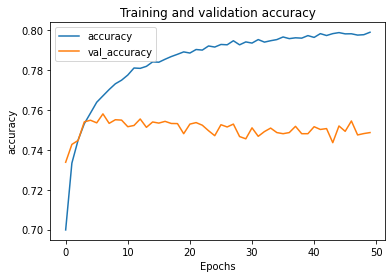

In [26]:
plot_fig(history,'accuracy')

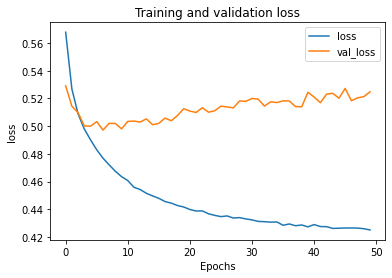

In [27]:
plot_fig(history,'loss')